# <font color="orange">Load modules</font> 

In [12]:
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import datasets, layers, models
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_jupyter_B import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [13]:
y = load_images_label_csv("face_shape")

The following code is to remove the test_set in case this has been moved from cartoon_set_test/img to cartoon_set/img. Indeed the main.py program required train, validation and test sets to be located in the same folder.

In [14]:
if count_n_images(sub_folder, extension) > 10000:
    move_images_fromfolder(sub_folder, sub_test_folder, extension)

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Haar Cascade Classifier. This is an effective object detection approach which was proposed by Paul Viola and Michael Jones back in 2001. This is basically a machine learning based approach where a cascade function is trained from a lot of images and then used to detect the objects in the other images. Specific .xml files will allow us to extract different features. Further to this process, the **ImageManager** class operates a Canny Edge detection step in addition to cropping. By specifying the hysteresis parameters, we can optimize the final choice of the edge.

In [15]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True)
imgmgr.bodypart = "face"
imges = imgmgr.crop_part((100,100), squaring=False, x_offsets=(0,0), y_offsets = (0,0))
imges = imgmgr.canny_images()

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/cartoon_set/img/ with extension .png
723/10000 images loaded
1536/10000 images loaded
2303/10000 images loaded
3013/10000 images loaded
3688/10000 images loaded
4368/10000 images loaded
5051/10000 images loaded
5726/10000 images loaded
6389/10000 images loaded
7035/10000 images loaded
7707/10000 images loaded
8385/10000 images loaded
9092/10000 images loaded
9823/10000 images loaded
10000/10000 images loaded


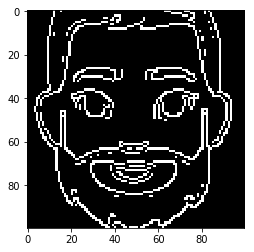

In [16]:
rgb = cv2.cvtColor(imges[5], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [17]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 1. Random Forest

Now we build our model using a Random Forest classifier. It is noticeable that by reducing the input vector size, ie resizing the shape of processed images, the Random Forest classifier returns a higher accuracy on the training set. It is also noticeable that overfitting is present as there is almost 100% precision on the training set. Also the "max_depth" argument contributes significantly to our model performance. More complex trees return higher accuracy.

In order to reduce overfitting, the "max_leaf_nodes" argument has been set to a specific number. This will prune the overall tree structure.

In [7]:
clf = RandomForestClassifier(n_estimators = 80, 
                             max_depth = 100, 
                             criterion = "entropy",
                             max_leaf_nodes = 130,
                             max_features="auto")
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1491
           1       0.97      0.89      0.93      1484
           2       0.89      0.94      0.92      1500
           3       0.95      0.88      0.91      1503
           4       0.83      0.96      0.89      1522

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500

TEST METRICS
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       509
           1       0.82      0.70      0.75       516
           2       0.68      0.82      0.74       500
           3       0.81      0.68      0.74       497
           4       0.68      0.87      0.76       478

    accuracy                           0.77      2500
   macro avg       0.78      0.77      0.77      2500
weighted avg       0.78      0.77      0.77      2

No handles with labels found to put in legend.


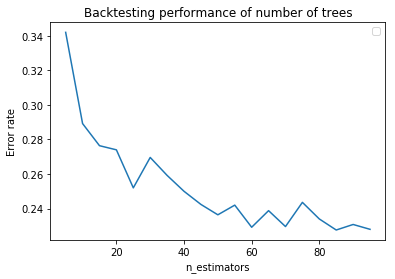

In [8]:
n_estimators=np.arange(5, 100, 5)

# Dictionary containing (<n_estimators>, <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

We present the confusion matrix once data has been trained using Random Forest.

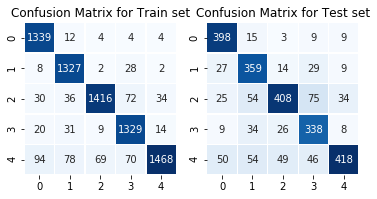

In [9]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

Now we perform some hyper-parameter tuning to see if other Random Forest arguments would have led to a significantly higher performance. The below dictionary will test 3 different sizes of n_estimators, 2 of max_leaf_nodes and 2 of max_features. A table with score results is presented below.

In [10]:
param_grid = {"n_estimators":   [40, 60, 80],
              "max_leaf_nodes": [90, 130],
              "max_features":   ["auto", "sqrt", "log2"]}

In [11]:
grid_clf = sklearn.model_selection.GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              max_depth=100, max_leaf_nodes=130,
                                              n_estimators=95),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [90, 130],
                         'n_estimators': [40, 60, 80]})

In [12]:
results_table = pd.DataFrame.from_dict(grid_clf.cv_results_).set_index("rank_test_score")
results_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,
12,2.543408,0.065434,0.042109,0.006834,auto,90,40,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.746000,0.725333,0.705333,0.723333,0.742667,0.728533,0.014699
9,3.795840,0.151148,0.046643,0.002371,auto,90,60,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.732000,0.752667,0.710667,0.726667,0.747333,0.733867,0.015022
5,5.128712,0.225170,0.062619,0.011429,auto,90,80,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.752000,0.752667,0.720667,0.748000,0.763333,0.747333,0.014267
7,2.715402,0.074978,0.038476,0.004436,auto,130,40,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.754000,0.737333,0.718667,0.728667,0.761333,0.740000,0.015759
3,4.483876,0.234780,0.059209,0.011018,auto,130,60,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.768000,0.770000,0.734000,0.756000,0.761333,0.757867,0.012923
1,5.735185,0.589765,0.070708,0.022102,auto,130,80,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.769333,0.766667,0.739333,0.755333,0.766667,0.759467,0.011167
11,2.462241,0.059256,0.040101,0.001056,sqrt,90,40,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.735333,0.746667,0.698667,0.725333,0.742000,0.729600,0.017047
10,3.966054,0.306277,0.048772,0.005305,sqrt,90,60,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.734000,0.748667,0.715333,0.728000,0.740667,0.733333,0.011329
8,5.317343,0.356172,0.061145,0.011568,sqrt,90,80,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.734667,0.742667,0.726000,0.730667,0.750667,0.736933,0.008780


### 2. Convolutional Neural Network

Resize and manipulate the train and tests sets in order to be in the right format for the CNN implementation, ie in tensor format.

In [18]:
X = X.reshape(10000,100,100,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

In [19]:
nb_filters = 16 # for convolutional layer
nb_pool = 8 # for MaxPool layer
nb_conv = 3 # for convolutional layer
nb_classes = 5 # for dense layer, multiclassification problem
activation = layers.LeakyReLU(alpha=0.3)

model = models.Sequential()

model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation=activation, input_shape=X.shape[1:]))
model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation=activation))
model.add(layers.MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=activation))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                147520    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 43s 182ms/step - loss: 10.7852 - accuracy: 0.2345 - val_loss: 1.5713 - val_accuracy: 0.3172
Epoch 2/10
235/235 [==============================] - 44s 186ms/step - loss: 1.7766 - accuracy: 0.3085 - val_loss: 1.2606 - val_accuracy: 0.5168
Epoch 3/10
235/235 [==============================] - 44s 187ms/step - loss: 1.4128 - accuracy: 0.4544 - val_loss: 0.9591 - val_accuracy: 0.6772
Epoch 4/10
235/235 [==============================] - 43s 182ms/step - loss: 1.1302 - accuracy: 0.5757 - val_loss: 0.7243 - val_accuracy: 0.7696
Epoch 5/10
235/235 [==============================] - 43s 184ms/step - loss: 0.9461 - accuracy: 0.6532 - val_loss: 0.6219 - val_accuracy: 0.7748
Epoch 6/10
235/235 [==============================] - 44s 188ms/step - loss: 0.8129 - accuracy: 0.7040 - val_loss: 0.5188 - val_accuracy: 0.8136
Epoch 7/10
235/235 [==============================] - 44s 185ms/step - loss: 0.7384 - accuracy: 0.7367 - val_loss: 0.4665 - val_a

In [21]:
Y_pred_test = np.argmax(model.predict(X_test), axis=1)
Y_pred_train = np.argmax(model.predict(X_train), axis=1)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(Y_train, Y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(Y_test, Y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1499
           1       0.91      0.91      0.91      1515
           2       0.95      0.90      0.93      1498
           3       0.88      0.90      0.89      1510
           4       0.90      0.97      0.94      1478

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500

TEST METRICS
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       501
           1       0.83      0.85      0.84       485
           2       0.91      0.85      0.88       502
           3       0.81      0.82      0.82       490
           4       0.89      0.97      0.93       522

    accuracy                           0.88      2500
   macro avg       0.88      0.87      0.87      2500
weighted avg       0.88      0.88      0.88      2

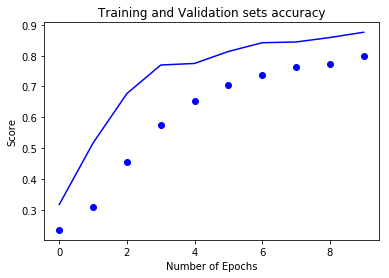

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training set accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation set accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.title('Training and Validation sets accuracy')
plt.show()

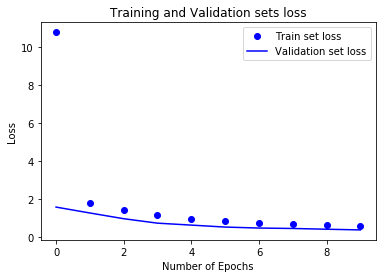

In [23]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Train set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation sets loss')
plt.legend()
plt.show()